In [21]:
import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal
from torch.distributions import Categorical
import torch.nn.functional as F
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
import gym.vector
import cv2
import numpy as np
from gym.wrappers import GrayScaleObservation
import PIL
from PIL import Image
from IPython.core.display import clear_output

print(Image.__file__)

/home/lharms/.local/lib/python3.10/site-packages/PIL/Image.py


/tmp/ipykernel_223552/792723323.py:16: DeprecationWarning: Importing clear_output from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import clear_output


## Actor Critic

In [22]:
class ActorCritic(nn.Module):
    def __init__(self, action_dim):
        super(ActorCritic, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten()
        )

        self.actor = nn.Sequential(
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, action_dim),
            nn.Softmax(dim=-1)
        )

        self.critic = nn.Sequential(
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )

    def extract_features(self, state):
        return self.cnn(state)

    def act(self, state):
        with torch.no_grad():
            features = self.extract_features(state)
            probs = self.actor(features)
            dist = Categorical(probs)
            action = dist.sample()
            return action.item(), dist.log_prob(action)

    def evaluate(self, states, actions):
        features = self.extract_features(states)
        probs = self.actor(features)
        dist = Categorical(probs)
        log_probs = dist.log_prob(actions)
        entropy = dist.entropy()
        values = self.critic(features).squeeze(-1)
        return log_probs, entropy, values

#### A2C

In [23]:
class A2C:
    def __init__(self, action_dim, lr_actor, lr_critic, gamma):
        self.policy = ActorCritic(action_dim).to('cpu')
        self.optimizer = torch.optim.Adam([
            {'params': self.policy.cnn.parameters(), 'lr': lr_actor},
            {'params': self.policy.actor.parameters(), 'lr': lr_actor},
            {'params': self.policy.critic.parameters(), 'lr': lr_critic}
        ])
        self.gamma = gamma

    def select_action(self, state):
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to('cpu')  # (1, 4, 84, 84)
        return self.policy.act(state_tensor)

    def compute_returns(self, rewards, dones, last_value):
        R = last_value
        returns = []
        for reward, done in zip(reversed(rewards), reversed(dones)):
            if done:
                R = 0
            R = reward + self.gamma * R
            returns.insert(0, R)
        return returns

    def update(self, states, actions, log_probs, rewards, dones):
        device = 'cpu'

        # Letzter Wert für Bootstrapping
        with torch.no_grad():
            last_state = torch.FloatTensor(states[-1]).unsqueeze(0).to(device)
            last_value = self.policy.critic(self.policy.extract_features(last_state)).item()

        returns = self.compute_returns(rewards, dones, last_value)
        returns = torch.tensor(returns, dtype=torch.float32).to(device)
        states_tensor = torch.tensor(states, dtype=torch.float32).to(device)  # (T, 4, 84, 84)
        actions_tensor = torch.tensor(actions, dtype=torch.long).to(device)

        log_probs_tensor, entropy, values = self.policy.evaluate(states_tensor, actions_tensor)
        advantages = returns - values.detach()

        actor_loss = - (log_probs_tensor * advantages).mean()
        critic_loss = F.mse_loss(values, returns)

        loss = actor_loss + 0.5 * critic_loss - 0.05 * entropy.mean()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

#### environment

In [24]:
import gym

#This environment wrapper is used to stop a run if mario is stuck on a pipe
class DeadlockEnv(gym.Wrapper):
    def __init__(self, env, threshold=60):
        super().__init__(env)
        self.last_x_pos = 0
        self.count = 0
        self.threshold = threshold
        self.lifes = 3
        self.stage = 1
        self.world = 1

    def reset(self, **kwargs):
        self.last_x_pos = 0
        self.count = 0
        return self.env.reset(**kwargs)

    def step(self, action):
        state, reward, done, info = self.env.step(action)
        x_pos = info['x_pos']

        if x_pos <= self.last_x_pos:
            self.count += 1
        else:
            self.count = 0
            self.last_x_pos = x_pos

        if info['life'] != self.lifes or info["stage"] != self.stage or info["world"] != self.world:
            self.last_x_pos = x_pos
            self.count = 0
            self.lifes = info['life']
            self.stage = info["stage"]
            self.world = info["world"]

        if self.count >= self.threshold:
            reward = -15
            done = True

        return state, reward, done, info

#skipframe wrapper
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        reward_out = 0
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            reward_out += reward
            if done:
                break
        reward_out /= max(1,i+1)

        return obs, reward_out, done, info

#downsample wrapper to reduce dimensionality
def Downsample(ratio,state):
  (oldh, oldw, oldc) = state.shape
  newshape = (oldh//ratio, oldw//ratio, oldc)
  frame = cv2.resize(state, (newshape[0], newshape[1]), interpolation=cv2.INTER_AREA)
  return frame

#small function to change rgb images to grayscale
def GrayScale(state):
  return cv2.cvtColor(state, cv2.COLOR_RGB2GRAY)



#### Training

In [25]:
#renders given frames with mediapy and shows a video
def renderEnv(frames):
  import mediapy as media
  media.show_video(frames,fps=60//4)

#plot for visualizing results
def plotRewardandTime(avg_norm_reward,avg_length):
  import matplotlib.pyplot as plt
  x = np.arange(len(avg_norm_reward))

  fig, axs = plt.subplots(1, 2,figsize=(9,3))

  axs[0].plot(x, avg_norm_reward)
  axs[0].set_title("avg_norm_reward")

  axs[1].plot(x, avg_length)
  axs[1].set_title("avg_length")
  plt.show()

def save_video_cv2(frames, path, fps=15):
    height, width, _ = frames[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec für .mp4
    out = cv2.VideoWriter(path, fourcc, fps, (width, height))

    for frame in frames:
        bgr_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        out.write(bgr_frame)

    out.release()

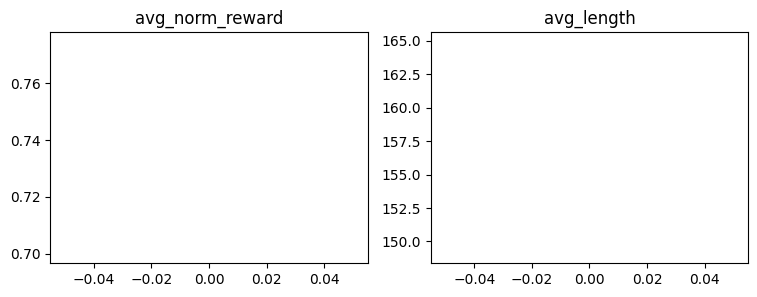

Epoch 1 | Reward: 115.75 | Avg Reward (last 50): 115.75


In [26]:
frameskip = 4
down_sample_rate = 4
lr_actor = 0.0003
lr_critic = 0.001
gamma = 0.99

env = gym_super_mario_bros.make('SuperMarioBros-v1')
env = JoypadSpace(env, SIMPLE_MOVEMENT)
env = SkipFrame(env, skip=frameskip)                  #Skipframewrapper to skip some frames
env = DeadlockEnv(env,threshold=(60*2)//frameskip)
state = env.reset()

action_dim = env.action_space.n # action space dimension

agent = A2C(action_dim=action_dim, lr_actor=lr_actor, lr_critic=lr_critic, gamma=gamma)

done = False
log_probs, states, actions, rewards, dones = [], [], [], [], []

frame_stack = 4
states_buffer = [np.zeros((84, 84), dtype=np.float32) for _ in range(frame_stack - 1)]
for i, f in enumerate(states_buffer):
    if f.shape != (84, 84):
        print(f"Invalid shape at index {i}: {f.shape}")



avg_reward_temp, avg_length_temp, avg_norm_reward_temp = [], [], []
avg_reward, avg_length, avg_norm_reward = [], [], []

max_training_epochs = 1
max_ep_len = 10000
updates = 0
episode_list = []

for epoch in range(max_training_epochs):
    state = env.reset()
    episode_reward = 0
    states, actions, log_probs, rewards, dones = [], [], [], [], []

    frames = []  # Optional: Für Visualisierung

    for t in range(max_ep_len):
        env.render()

        # Bild vorbereiten
        # Statt flatten() → 84x84 behalten
        in_state = GrayScale(Downsample(down_sample_rate, state.copy()))  # shape: (84, 84)
        in_state = cv2.resize(in_state, (84, 84))
        states_buffer.append(in_state / 255.0)
        states_buffer = states_buffer[-frame_stack:]


        # Aktion auswählen
        stacked_input = np.stack(states_buffer, axis=0)  # shape: (4, 84, 84)
        action, log_prob = agent.select_action(stacked_input)

        # Schritt durchführen
        next_state, reward, done, info = env.step(action)

        # Speichern
        states.append(stacked_input)
        actions.append(action)
        log_probs.append(log_prob)
        rewards.append(reward)
        dones.append(done)

        state = next_state
        episode_reward += reward

        if not done:
            frames.append(state.copy())

        if done:
            break

    avg_reward_temp.append(episode_reward)
    avg_length_temp.append(t)
    avg_norm_reward_temp.append(episode_reward / max(1, t))


    if len(frames) > 0:
        episode_list.append((episode_reward, frames))
    else:
        episode_list.append((episode_reward, []))  # oder ggf. letzte Frames speicher

    if epoch % 10 == 0:
        agent.update(states, actions, log_probs, rewards, dones)
        updates += 1

        avg_reward.append(np.median(avg_reward_temp))
        avg_length.append(np.median(avg_length_temp))
        avg_norm_reward.append(np.median(avg_norm_reward_temp))

        avg_reward_temp.clear()
        avg_length_temp.clear()
        avg_norm_reward_temp.clear()

        clear_output(wait=True)
        episode_list.sort(key=lambda x: x[0])  # Sortiere nach Reward

        print("Updating at epoch", epoch)
        print("--------------------------------")
        print("Epoch", epoch, "done:")
        print("Update iterations:", updates)
        print("Statistics:")
        print("")
        print("Reward of best episode:", episode_list[-1][0])
        print("Length of best episode:", len(episode_list[-1][1]))
        print("")
        print("Average total reward:", np.mean(avg_reward[-50:]))
        print("Average normalized reward:", np.mean(avg_norm_reward[-50:]))
        print("Average length:", np.mean(avg_length[-50:]))
        print("--------------------------------")

        plotRewardandTime(avg_norm_reward, avg_length)
        renderEnv(episode_list[-1][1])

        # Nur alte Episoden löschen, falls Liste zu lang
        if len(episode_list) > 10:
            episode_list = episode_list[-10:]


    print(f"Epoch {epoch + 1} | Reward: {episode_reward:.2f} | Avg Reward (last 50): {np.mean(avg_reward[-50:]):.2f}")

    if epoch % 100 == 0:
        torch.save(agent.policy.state_dict(), f"../../runs/A2C/03_testA2C/01start/a2c_epoch_{epoch}.pt")

    save_video_cv2(frames, f"../../runs/A2C/videos/mario_epoch{epoch}.mp4")

env.close()